# Code Challenge - Transfer Learning - Letters to Numbers

Train CNN on Letters dataset.  
Freeze the architecture of CNN, except for feed-forward layers  
Change output layers to accommodate 10 digits and fine-tune the model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import copy
from sklearn.model_selection import train_test_split

import torchvision

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Letters and digits dataset
letter_data = torchvision.datasets.EMNIST(root='emnist',split='letters',download=True)
number_data = torchvision.datasets.EMNIST(root='emnist',split='digits',download=True)

In [4]:
# transformation on letter data

# removing N/A classes
cat = cdata.classes[1:]
labels = copy.deepcopy(cdata.targets) - 1

imgs = letter_data.data.view([letter_data.data.shape[0],1,28,28]).float()
imgs /= torch.max(imgs)

X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=.1)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

bs = 32
Letter_trainLoader = DataLoader(train_ds, batch_size=bs, shuffle=True, drop_last=True)
Letter_testLoader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

NameError: name 'cdata' is not defined

In [ ]:
# transformation on number data

n_imgs = number_data.data.view([number_data.data.shape[0],1,28,28]).float()
n_imgs /= torch.max(n_imgs)

X_train, X_test, y_train, y_test = train_test_split(n_imgs, number_data.targets, test_size=.1)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

batchsize = 32
digit_trainLoader = DataLoader(train_ds, batch_size=batchsize, shuffle=True, drop_last=True)
digit_testLoader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

In [ ]:
# visualize some letters
fig,axs = plt.subplots(3,7,figsize=(13,6))

# get a batch of letter data
X,y = next(iter(Letter_trainLoader))

for i,ax in enumerate(axs.flatten()):
  
  # extract the image and its target letter
    I = np.squeeze( X[i,:,:] )
    letter = cat[y[i]]

    # visualize
    ax.imshow(I.T,cmap='gray',vmin=0,vmax=1)
    ax.set_title('The letter "%s"'%letter,fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [ ]:
# visualize some numbers
fig,axs = plt.subplots(3,7,figsize=(13,6))

# get a batch of number data
X,y = next(iter(digit_trainLoader))

for i,ax in enumerate(axs.flatten()):
  
    # extract the image and its target letter
    I = np.squeeze( X[i,:,:] )
    number = y[i].item()

    # visualize
    ax.imshow(I.T,cmap='gray',vmin=0,vmax=1)
    ax.set_title('The number "%s"'%number,fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [ ]:
def makeNet(printtoggle=False):
    
    class EMNIST(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()
            
            # print toggle
            self.print = printtoggle
            
            # Feature map layers
            
            self.conv1 = nn.Conv2d(1,6,3,padding=1)
            self.bnorm1 = nn.BatchNorm2d(6) # no. of ip channels in this layer
            
            # op size = (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 -> maxpool)
            
            self.conv2 = nn.Conv2d(6,6,3,padding=1)
            self.bnorm2 = nn.BatchNorm2d(6) # no. of ip channels in this layer
            # op size = (14+2*0-3)/1 + 1 = 12/2 = 6
            
            # Linear layers
            self.fc1 = nn.Linear(7*7*6, 50)
            self.fc2 = nn.Linear(50,26)
            
        def forward(self, x):
            if self.print:
                print(f'Input: {list(x.shape)}')
            
            # first block : conv -> maxpool -> batchnorm ->relu
            x = F.max_pool2d(self.conv1(x), 2)
            x = F.leaky_relu(self.bnorm1(x))
            
            if self.print:
                print(f'First CPR block: {list(x.shape)}')
                
            # second block : conv -> maxpool -> batchnorm ->relu
            x = F.max_pool2d(self.conv2(x), 2)
            x = F.leaky_relu(self.bnorm2(x))
            
            if self.print:
                print(f'Second CPR block: {list(x.shape)}')
              
            # reshaping for linear layer
            nU = x.shape.numel()/x.shape[0]
            x = x.view(-1,int(nU))
            if self.print:
                print(f'Vectorized: {list(x.shape)}')
            
            x = F.leaky_relu(self.fc1(x))
            x = self.fc2(x)
            
            if self.print:
                print(f'Output: {list(x.shape)}')
            
            return x
        
    net = EMNIST(printtoggle)
    lossfn = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(net.parameters(), lr=.001)
    
    return net, lossfn, optim

In [ ]:
def trainModel(net, trainLoader, testLoader, numepochs=10):
    nEp = numepochs
        
    net.to(device)
    
    trainLoss = torch.zeros(nEp)
    testLoss = torch.zeros(nEp)
    trainErr = torch.zeros(nEp)
    testErr = torch.zeros(nEp)
    
    for i in range(nEp):
        net.train()
        
        batchLoss = []
        batchErr = []
        
        for X, y in trainLoader:
            X = X.to(device)
            y = y.to(device)
            
            yH = net(X)
            loss = lossfn(yH, y)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            # loss and error from this batch
            batchLoss.append(loss.item())
            batchErr.append( torch.mean((torch.argmax(yH,axis=1) != y).float()).item() )
            torch.cuda.empty_cache()
        # end of batch loop
        
        trainLoss[i] = np.mean(batchLoss)
        trainErr[i] = 100*np.mean(batchErr)
        
        # test performance
        net.eval()
        X,y = next(iter(testLoader))
        X = X.to(device)
        y = y.to(device)
        
        with torch.no_grad():
            yH = net(X)
            loss = lossfn(yH, y)
        
        testLoss[i] = loss.item()
        testErr[i] = 100*torch.mean((torch.argmax(yH,axis=1) != y).float()).item()
        
    
    return net, trainLoss, testLoss, trainErr, testErr

In [ ]:
lnet, lossfn, optim = makeNet()

lnet, trainLoss, testLoss, trainErr, testErr = trainModel(lnet, Letter_trainLoader, Letter_testLoader, 5)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
# accuracy
print('Train Accuracy :', 100 - trainErr[-1].item())
print('Test Accuracy:', 100 -testErr[-1].item())

### Testing the model on number data

In [ ]:
# extract X,y from NUMBER test dataloader
X,y = next(iter(digit_testLoader))
X = X.to(device)
y = y.to(device)

lnet.eval()
yHat = lnet(X)

# the test
numberAcc = 100*torch.mean((torch.argmax(yHat,axis=1)!=y).float())

print(f'numberNet error rate on NUMBER data: {numberAcc:.2f}%')

### Fine-tuning from scratch using digits data and training only for one epoch

In [ ]:
dnet, lossfn, optim = makeNet()

# replace all of weights in target model (f_net) from our source model (original mnist net)
for tgt, src in zip(dnet.named_parameters(), lnet.named_parameters()):
    tgt[1].data = copy.deepcopy(src[1].data)

# changing the output layer to 10 units
dnet.fc2 = nn.Linear(50, 10)
dnet

In [ ]:
# retraining from scratch

dnet, trainLoss, testLoss, trainErr, testErr = trainModel(dnet, digit_trainLoader, digit_testLoader, 1)

In [ ]:
print('Train Error :', trainErr[-1].item())
print('Test Error:', testErr[-1].item())
dnet.fc2

### Freezing CNN layers and retraining only feed forward layers

In [ ]:
dnet2, lossfn, optim = makeNet()


# replace all of weights in target model (f_net) from our source model (original mnist net)
for tgt, src in zip(dnet2.named_parameters(), lnet.named_parameters()):
    tgt[1].data = copy.deepcopy(src[1].data)
    
# changing op layer
dnet2.fc2 = nn.Linear(50, 10)

for i in dnet2.named_parameters():
    if 'fc' not in i[0]:
        i[1].requires_grad = False

In [ ]:
dnet2

In [ ]:
for p in dnet2.named_parameters():
    print('Requires_grad status in layer %s: %s' %(p[0],p[1].requires_grad))

In [ ]:
# training for only one batch

dnet2, trainLoss, testLoss, trainErr, testErr = trainModel(dnet2, digit_trainLoader, digit_testLoader, 1)
# accuracy
print('Train Error :', trainErr[-1].item())
print('Test Error:', testErr[-1].item())

In [ ]:
dnet2

# Code Challenge - VCG-16

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import copy
from sklearn.model_selection import train_test_split

import torchvision
import torchvision.transforms as T

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# transformations
transform = T.Compose([
    T.ToTensor(), # normalizes to range (0,1)
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.STL10(root='../data/', download=True, split='train',transform=transform)
testset = torchvision.datasets.STL10(root='../data/', download=True, split='test',transform=transform)

batchsize = 32
trainLoader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
testLoader = DataLoader(testset, batch_size=256)

In [ ]:
vgg16 = torchvision.models.vgg16(pretrained=True)

In [ ]:
from torchsummary import summary
summary(vgg16.to(device), (3,96, 96))

In [ ]:
# freezing vgg16 layers 
for i in vgg16.parameters():
    i.requires_grad = False

In [ ]:
# Changing final layer
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 10)

In [ ]:
# training the model

lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.parameters(),lr=0.001)

numepochs = 10

# initialize losses
trainLoss = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)
trainAcc  = torch.zeros(numepochs)
testAcc   = torch.zeros(numepochs)

vgg16.to(device)

# loop over epochs
for epochi in range(numepochs):

    # loop over training data batches
    
    vgg16.train() # switch to train mode
    batchLoss = []
    batchAcc  = []
    for X,y in trainLoader:

        # push data to GPU
        X = X.to(device)
        y = y.to(device)

        # forward pass and loss
        yHat = vgg16(X)
        loss = lossfun(yHat,y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)


    #### test performance (here done in batches!)
    vgg16.eval() # switch to test mode
    batchAcc  = []
    batchLoss = []
    for X,y in testLoader:

        # push data to GPU
        X = X.to(device)
        y = y.to(device)

        # forward pass and loss
        with torch.no_grad():
            yHat = vgg16(X)
            loss = lossfun(yHat,y)

        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
        # end of batch loop...

    # and get average losses and accuracies across the batches
    testLoss[epochi] = np.mean(batchLoss)
    testAcc[epochi]  = 100*np.mean(batchAcc)

    # print out a status update
    print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {testAcc[epochi]:.2f}%')


In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained VGG-16 on STL10 data',fontweight='bold',fontsize=14)
plt.show()

In [ ]:
# inspect a few random images

X,y = next(iter(testLoader))
X = X.to(device)
y = y.to(device)
vgg16.eval()
predictions = torch.argmax( vgg16(X) ,axis=1)


fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

    # extract that image (need to transpose it back to 96x96x3)
    pic = X.data[i].cpu().numpy().transpose((1,2,0))
    pic = pic-np.min(pic) # undo normalization
    pic = pic/np.max(pic)

    # show the image
    ax.imshow(pic)


    # label and true class
    label = trainset.classes[predictions[i]]
    truec = trainset.classes[y[i]]
    title = f'Pred: {label}  -  true: {truec}'

    # set the title with color-coded accuracy
    titlecolor = 'g' if truec==label else 'r'
    ax.text(48,90,title,ha='center',va='top',fontweight='bold',color='k',backgroundcolor=titlecolor,fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Code Challenge - Style transfer with AlexNet

# Style transfer on Screaming Bathtub

In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

# to read an image from a url
from imageio import imread

# for number-crunching
import numpy as np

import warnings; warnings.filterwarnings('ignore')

# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [2]:
# import the model
alexnet = torchvision.models.alexnet(pretrained=True)

# freeze all layers
for p in alexnet.parameters():
    p.requires_grad = False
    
# set to evaluation mode
alexnet.eval();

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
alexnet.to(device);

## Importing two images

In [4]:
img4content = imread('https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg')
img4style   = imread('https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg')

# initialize the target image and random numbers
img4target = np.random.randint(low=0,high=255,size=img4content.shape,dtype=np.uint8)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

(1675, 3000, 3)
(1675, 3000, 3)
(4000, 3223, 3)


In [5]:
## These images are really large, which will make training take a long time. 

# create the transforms
Ts = T.Compose([ T.ToTensor(),
                 T.Resize(256),
                 T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
               ])

# apply them to the images ("unsqueeze" to make them a 4D tensor) and push to GPU
img4content = Ts( img4content ).unsqueeze(0).to(device)
img4style   = Ts( img4style   ).unsqueeze(0).to(device)
img4target  = Ts( img4target  ).unsqueeze(0).to(device)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

torch.Size([1, 3, 256, 458])
torch.Size([1, 3, 256, 458])
torch.Size([1, 3, 317, 256])


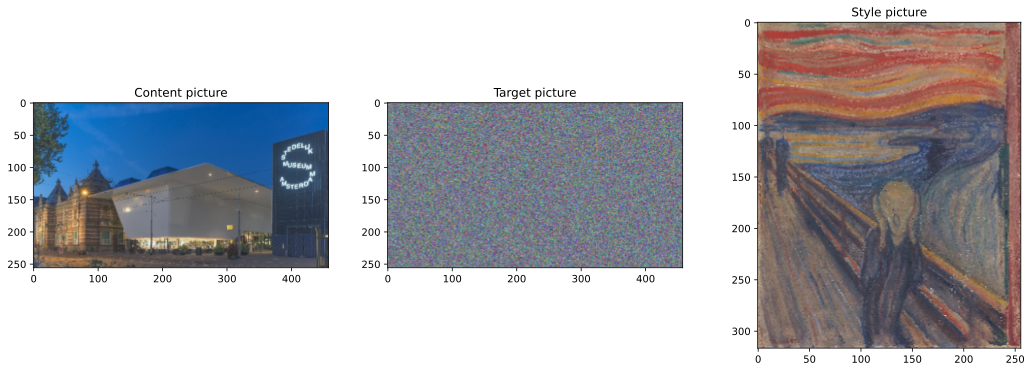

In [6]:
# Let's have a look at the "before" pics
fig,ax = plt.subplots(1,3,figsize=(18,6))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture')

pic = img4target.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[1].imshow(pic)
ax[1].set_title('Target picture')

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Style picture')

plt.show()

## Functions to extract image feature map activations

In [7]:
# function returning feature map for an input image

def getFeatureMap(img, net):
    
    fmap = []
    fname = []
    
    convLayeridx = 0 # layer after which feature map is required
    
    # looping through all layers in 'features' block
    for lnum in range(len(net.features)):
        
        # processing img through the layer 
        img = net.features[lnum](img)
        
        # store image if its a conv2d layer
        if 'Conv2d' in str(net.features[lnum]):
            fmap.append(img)
            fname.append('ConvLayer_'+str(convLayeridx))
            convLayeridx += 1
            
    return fmap, fname

In [8]:
# function to return gram matrix of a feature activation map

def gram_matrix(M):
    # reshape to 2D
    _, chans, height, width = M.shape
    M = M.reshape(chans,height*width)
    
    gram = torch.mm(M,M.t())/(chans*height*width)
    
    return gram

In [9]:
# inspect the output of the function
featmaps,featnames = getFeatureMap(img4content,alexnet)

# print out some info
for i in range(len(featnames)):
  print('Feature map "%s" is size %s'%(featnames[i],(featmaps[i].shape)))

Feature map "ConvLayer_0" is size torch.Size([1, 64, 63, 113])
Feature map "ConvLayer_1" is size torch.Size([1, 192, 31, 56])
Feature map "ConvLayer_2" is size torch.Size([1, 384, 15, 27])
Feature map "ConvLayer_3" is size torch.Size([1, 256, 15, 27])
Feature map "ConvLayer_4" is size torch.Size([1, 256, 15, 27])


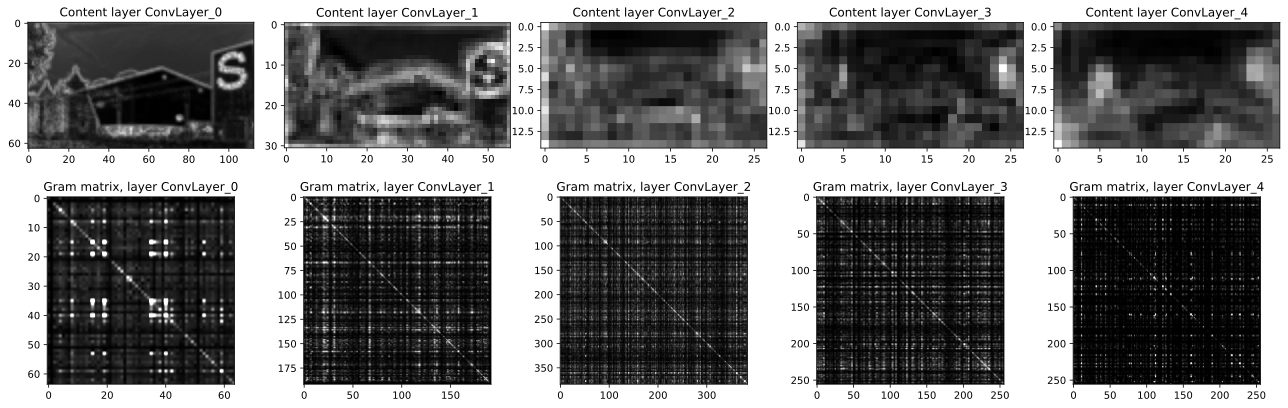

In [10]:
# let's see what the "content" image looks like
contentFeatureMaps,contentFeatureNames = getFeatureMap(img4content,alexnet)


fig,axs = plt.subplots(2,5,figsize=(18,6))
for i in range(5):

    # average over all feature maps from this layer, and normalize
    pic = np.mean( contentFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
    pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

    axs[0,i].imshow(pic,cmap='gray')
    axs[0,i].set_title('Content layer ' + str(contentFeatureNames[i]))


    ### now show the gram matrix
    pic = gram_matrix(contentFeatureMaps[i]).cpu().numpy()
    pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

    axs[1,i].imshow(pic,cmap='gray',vmax=.1)
    axs[1,i].set_title('Gram matrix, layer ' + str(contentFeatureNames[i]))

plt.tight_layout()
plt.show()

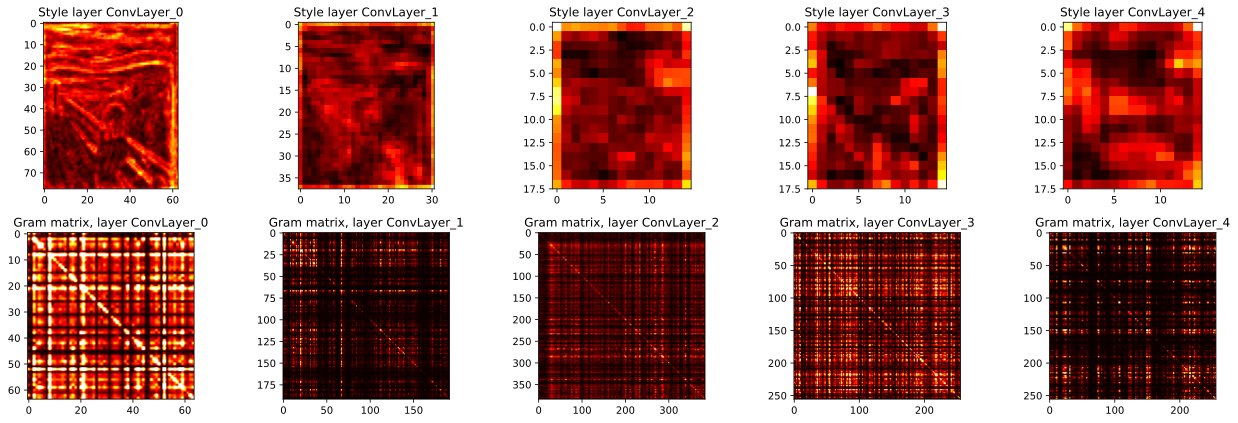

In [11]:
# repeat for the "style" image
styleFeatureMaps,styleFeatureNames = getFeatureMap(img4style,alexnet)


fig,axs = plt.subplots(2,5,figsize=(18,6))
for i in range(5):

    # average over all feature maps from this layer, and normalize
    pic = np.mean( styleFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
    pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

    axs[0,i].imshow(pic,cmap='hot')
    axs[0,i].set_title('Style layer ' + str(styleFeatureNames[i]))


    ### now show the gram matrix
    pic = gram_matrix(styleFeatureMaps[i]).cpu().numpy()
    pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

    axs[1,i].imshow(pic,cmap='hot',vmax=.1)
    axs[1,i].set_title('Gram matrix, layer ' + str(styleFeatureNames[i]))

plt.tight_layout()
plt.show()

## Transfer Process

In [12]:
# which layers to use

layers4content = [ 'ConvLayer_0']# ,'ConvLayer_4' ]
layers4style   = [ 'ConvLayer_0','ConvLayer_1','ConvLayer_2','ConvLayer_3','ConvLayer_4' ]
weights4style  = [      1       ,     .8      ,     .6      ,     .4      ,     .2       ]

In [13]:
# Making a copy of target image and pushing it to GPU

target = img4target.clone()
target.requires_grad = True
target = target.to(device)

# error terms for content and style processes are numerically different
# To provide proper loss, we scale the style error so that loss can be fairly considered
styleScaling = 5e4

nEp = 1500

# updating only target image
optim = torch.optim.RMSprop([target],lr=.005)

for i in range(nEp):
    
    # extracting target feature maps
    target_fmap, target_fname = getFeatureMap(target, alexnet)
    
    styleLoss = 0
    contentLoss = 0
    
    # looping over layers
    for layeri in range(len(target_fname)):
        
        # computing content loss - MSE
        if target_fname[layeri] in layers4content:
            contentLoss += torch.mean((target_fmap[layeri] - contentFeatureMaps[layeri])**2)
            
        # computing style loss
        if target_fname[layeri] in layers4style:
            
            # gram matrices
            g_target = gram_matrix(target_fmap[layeri])
            g_style = gram_matrix(styleFeatureMaps[layeri])
            
            styleLoss += torch.mean((g_target - g_style)**2)*weights4style[layers4style.index(target_fname[layeri])]
            
        
    comb_loss = styleScaling*styleLoss + contentLoss

    optim.zero_grad()
    comb_loss.backward()
    optim.step()

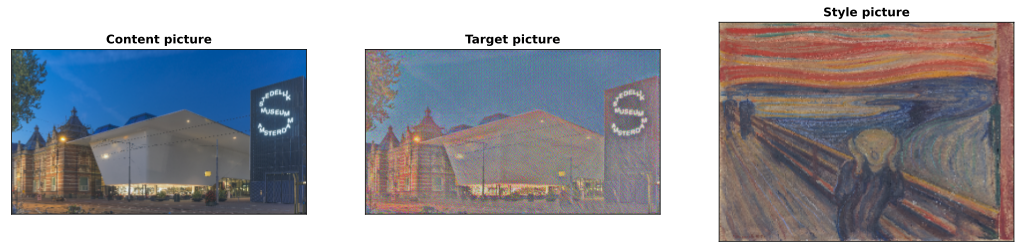

In [14]:
# the "after" pic
fig,ax = plt.subplots(1,3,figsize=(18,11))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture',fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
ax[1].imshow(pic)
ax[1].set_title('Target picture',fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic,aspect=.6)
ax[2].set_title('Style picture',fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

# Code Challenge - GANs

In [19]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import sys

import warnings; warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.Normalize(.5,.5),
                       ])

# import the data and simultaneously apply the transform
dataset = torchvision.datasets.FashionMNIST(root='./data', download=True, transform=transform)

In [22]:
# list the categories
print(dataset.classes)

# pick three categories (leave one line uncommented)
# classes2keep = [ 'Trouser','Sneaker','Pullover' ]
classes2keep = [ 'Trouser','Sneaker', 'Sandal'  ]



# find the corresponding data indices
images2use = torch.Tensor()
for i in range(len(classes2keep)):
    classidx = dataset.classes.index(classes2keep[i])
    images2use = torch.cat( (images2use,torch.where(dataset.targets==classidx)[0]), 0).type(torch.long)
    print(f'Added class {classes2keep[i]} (index {classidx})')

# now select just those images

# transform to dataloaders
batchsize   = 100
sampler     = torch.utils.data.sampler.SubsetRandomSampler(images2use)
data_loader = DataLoader(dataset,sampler=sampler,batch_size=batchsize,drop_last=True)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Added class Trouser (index 1)
Added class Sneaker (index 7)
Added class Sandal (index 5)


In [23]:
class discriminatorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 256)
        self.op = nn.Linear(256, 1)
        
    def forward(self, X):
        X = F.leaky_relu(self.fc1(X))
        X = F.leaky_relu(self.fc2(X))
        return torch.sigmoid(self.op(X))
    
dnet = discriminatorNet()
y = dnet(torch.randn(10,784))
y

tensor([[0.5094],
        [0.5146],
        [0.5188],
        [0.5115],
        [0.5031],
        [0.4776],
        [0.5531],
        [0.5028],
        [0.5182],
        [0.5271]], grad_fn=<SigmoidBackward0>)

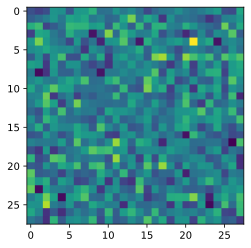

In [24]:
class generatorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(64, 256) # start from a latent space
        self.fc2 = nn.Linear(256, 256)
        self.op = nn.Linear(256, 784)

    def forward(self, X):
        X = F.leaky_relu(self.fc1(X))
        X = F.leaky_relu(self.fc2(X))
        return torch.tanh(self.op(X))
    
gnet = generatorNet()
y = gnet(torch.randn(10,64))
plt.imshow(y[0,:].detach().squeeze().view(28,28))

### Training models

In [25]:
lossfn = nn.BCELoss()

dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

# optimiziers
d_optim = torch.optim.Adam(dnet.parameters(), lr=.0003)
g_optim = torch.optim.Adam(gnet.parameters(), lr=.0003)

In [26]:
nEp = int(50000/len(data_loader))

losses = np.zeros((nEp*len(data_loader),2))
lossi  = 0

for i in range(nEp):
    
    for data, _ in data_loader:
        
        data = data.view(batchsize, -1).to(device)
        
        # labels for real and fake
        real_labels = torch.ones(batchsize, 1).to(device)
        fake_labels = torch.zeros(batchsize, 1).to(device)

        ### Training Discriminator

        # forward pass and loss for real pictures
        # It should know that these images are real
        pred_real = dnet(data)
        d_loss_real = lossfn(pred_real, real_labels)

        # forward pass and loss for fake pics
        # it should know that these are fake
        fake_img = gnet(torch.randn(batchsize,64).to(device))
        pred_fake = dnet(fake_img)
        d_loss_fake = lossfn(pred_fake, fake_labels)

        # combined loss
        d_loss = d_loss_fake + d_loss_real
        losses[i,0] = d_loss.item()

        # backprop
        d_optim.zero_grad()
        d_loss.backward()
        d_optim.step()

        ### Training generator

        # generate fake imgs and compute loss
        fake_img = gnet(torch.randn(batchsize,64).to(device))
        pred_fake = dnet(fake_img) # get prediction/decision from discriminator

        # loss and accuracy
        # gen thinks that they are real images,
        # Hence ground truth should be real always
        g_loss = lossfn(pred_fake, real_labels)
        losses[i,1] = g_loss.item()

        # backprop
        g_optim.zero_grad()
        g_loss.backward()
        g_optim.step()
        
        lossi += 1
    
    # print status
    sys.stdout.write('\r' + f'Finished epoch {i+1}/{nEp}')

Finished epoch 277/277

In [27]:
# create a 1D smoothing filter
def smooth(x,k=15):
  return np.convolve(x,np.ones(k)/k,mode='same')

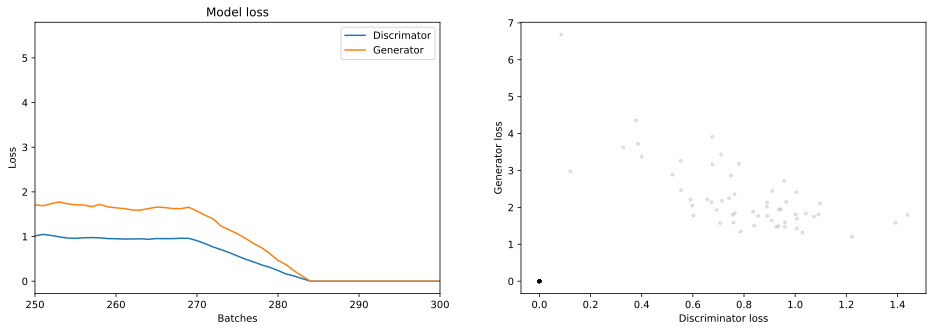

In [28]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
ax[0].set_xlim([250,300])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

plt.show()

## Some fake fashion

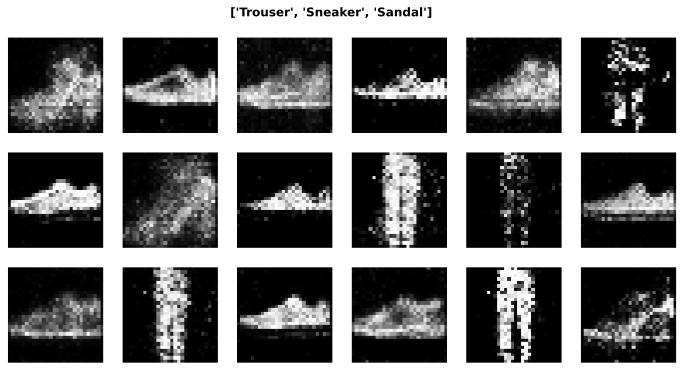

In [29]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet(torch.randn(18,64).to(device)).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
    ax.axis('off')

plt.suptitle(classes2keep,y=.95,fontweight='bold')
plt.show()

# Code Challenge - GANs - CNN with fewer layers

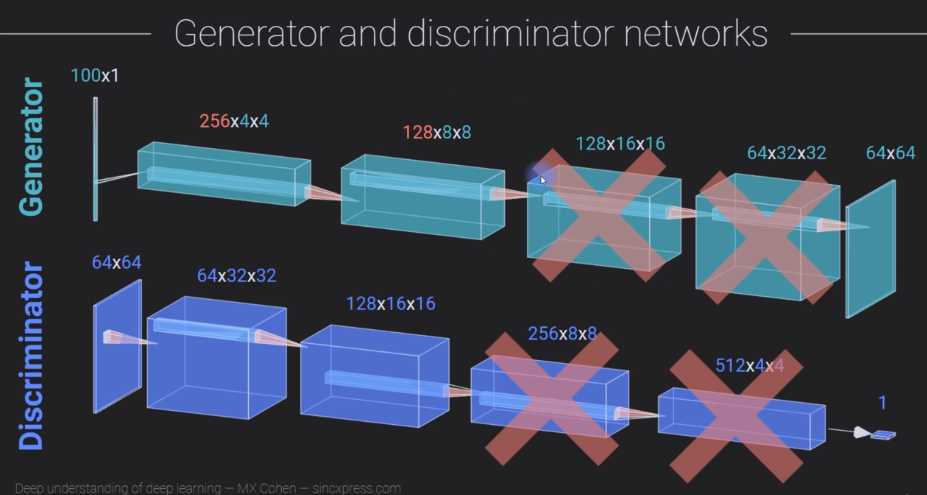

In [35]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys

import warnings; warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [37]:
nImages = 1000 # number of points per class
imgSize = 64 # 91x91 image

x = np.linspace(-4,4,imgSize) 
X,Y = np.meshgrid(x,x)

# sigma (arbitrary units)
widths = [1.8, 2.4]

# initializing tensors containing images and labels
imgs = torch.zeros(nImages, 1, imgSize, imgSize)

for i in range(nImages):
    
    # creating gaussians with random centers
    ro = 2*np.random.randn(2) # random offset
    G = np.exp(-((X - ro[0])**2 + (Y-ro[1])**2)/ (2*widths[i%2]**2))
    
    # add noise
    G += np.random.randn(imgSize, imgSize)/5
    
    # adding to tensor
    imgs[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

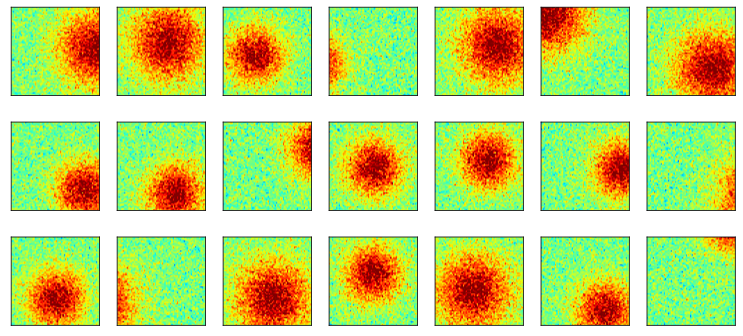

In [38]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nImages)
    G = np.squeeze( imgs[whichpic,:,:] )
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [39]:
## discriminator architecture

class discriminatorNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # conv layers
        self.conv1 = nn.Conv2d(1, 64, 4, 3, 0, bias=False)
        self.conv2 = nn.Conv2d(64, 128, 4, 3, 0, bias=False)
        self.conv3 = nn.Conv2d(128, 1, 4, 3, 0, bias=False)
        
        # batch norm
        self.bn2 = nn.BatchNorm2d(128)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), .2)
        x = F.leaky_relu(self.conv2(x), .2)
        x = self.bn2(x)
        x = F.leaky_relu(self.conv3(x), .2)
        return torch.sigmoid(x).view(-1, 1)

In [40]:
dnet = discriminatorNet()
y = dnet(torch.randn(10,1,64,64))
y.shape

torch.Size([10, 1])

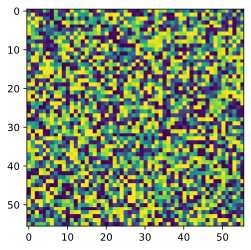

In [41]:
# generator architecture

class generatorNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # conv layers
        self.conv1 = nn.ConvTranspose2d(100, 256, 4, 4, 0, bias=False)
        self.conv2 = nn.ConvTranspose2d(256, 128, 4, 4, 1, bias=False)
        self.conv3 = nn.ConvTranspose2d(128, 1, 4, 4, 0, bias=False)
        
        # batch norm
        self.bn2 = nn.BatchNorm2d(128)
        self.bn1 = nn.BatchNorm2d(256)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), .2)
        x = self.bn1(x)
        x = F.leaky_relu(self.conv2(x), .2)
        x = self.bn2(x)
        x = self.conv3(x)
        return torch.tanh(x)
    
gnet = generatorNet()
y = gnet(torch.randn(10, 100, 1, 1))
plt.imshow(y[0,:,:,:].squeeze().detach().numpy());

In [42]:
lossfn = nn.BCELoss()

dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

# optimiziers
d_optim = torch.optim.Adam(dnet.parameters(), lr=.0002, betas=(.5,.999))
g_optim = torch.optim.Adam(gnet.parameters(), lr=.0002, betas=(.5,.999))

In [43]:
nEp = 1500
batchsize = 86
losses = []
disDecs = [] # discriminator decisions

for i in range(nEp):
    
    # mini batches of REAL and FAKE images
    randidx = torch.randint(imgs.shape[0], (batchsize,))
    data = imgs[randidx,:].to(device)
#     real_img = dataT[randidx,:].to(device)
    
    
    # labels for real and fake
    real_labels = torch.ones(batchsize, 1).to(device)
    fake_labels = torch.zeros(batchsize, 1).to(device)
    
    ### Training Discriminator
    
    # forward pass and loss for real pictures
    # It should know that these images are real
    pred_real = dnet(data)
    d_loss_real = lossfn(pred_real, real_labels)
    
    # forward pass and loss for fake pics
    # it should know that these are fake
    fake_img = gnet(torch.randn(batchsize,100,1,1).to(device))
    pred_fake = dnet(fake_img)
    d_loss_fake = lossfn(pred_fake, fake_labels)
    
    # combined loss
    d_loss = d_loss_fake + d_loss_real
    
    # backprop
    d_optim.zero_grad()
    d_loss.backward()
    d_optim.step()
    
    ### Training generator
    
    # generate fake imgs and compute loss
    fake_img = gnet(torch.randn(batchsize,100,1,1).to(device))
    pred_fake = dnet(fake_img) # get prediction/decision from discriminator
    
    # loss and accuracy
    # gen thinks that they are real images,
    # Hence ground truth should be real always
    g_loss = lossfn(pred_fake, real_labels)
    
    
    # backprop
    g_optim.zero_grad()
    g_loss.backward()
    g_optim.step()
    
    # losses and discriminator decisions
    losses.append([d_loss.item(), g_loss.item()])
    d1 = torch.mean((pred_real > .5).float()).detach()
    d2 = torch.mean((pred_fake > .5).float()).detach()
    disDecs.append([d1.cpu().item(), d2.cpu().item()])
    
    
    # print status
    if not (i+1)%50:
        sys.stdout.write('\r' + f'Finished epoch {i+1}/{nEp}')

Finished epoch 1500/1500

In [44]:
losses = np.array(losses)
disDecs = np.array(disDecs)

In [45]:
# create a 1D smoothing filter
def smooth(x,k=15):
    return np.convolve(x,np.ones(k)/k,mode='same')

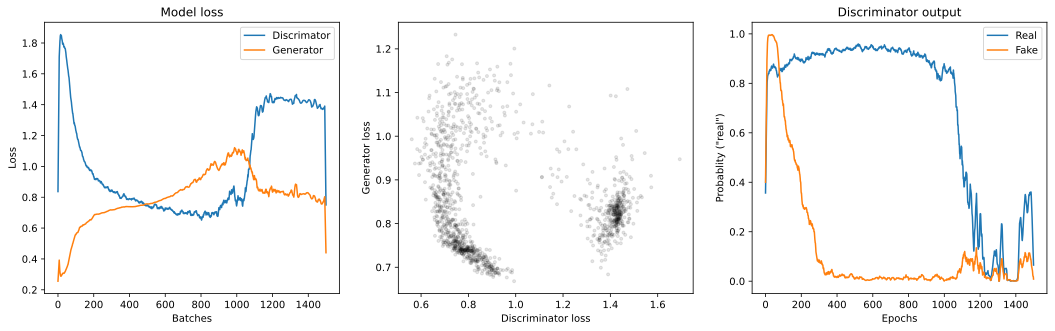

In [46]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([500,900])
# ax[0].set_ylim([0,2.5])

ax[1].plot(losses[200:,0],losses[200:,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(disDecs[:,0]))
ax[2].plot(smooth(disDecs[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

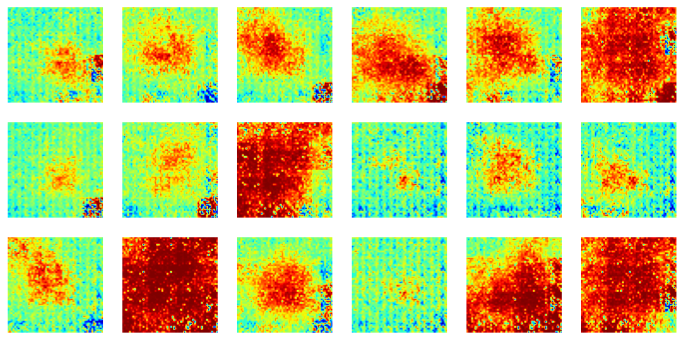

In [47]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet( torch.randn(batchsize,100,1,1).to(device) ).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    ax.imshow(fake_data[i,].detach().squeeze(),cmap='jet')
    ax.axis('off')

plt.show()

# Code Challenge - RNNs

In [16]:
### import libraries
import torch
import torch.nn as nn
import numpy as np

# for printing out status reports
import sys

import warnings; warnings.filterwarnings('ignore')
# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

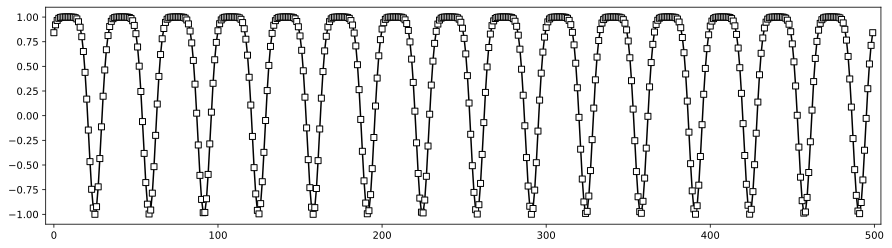

In [68]:
# import the data
N = 500

time = torch.linspace(0, 30*np.pi, N)
data = torch.sin(time + torch.cos(time))


plt.figure(figsize=(15,4))
plt.plot(data,'ks-',markerfacecolor='w')
plt.xlim([-5,N+4])
plt.show()

Above sequence has only one data stream/channel. Hence, input size will be 1

In [70]:
class RNNNet(nn.Module):
    def __init__(self, ip_size, nHidden, nLayers):
        super().__init__()
        
        # store parameters
        self.ip_size = ip_size
        self.nHidden = nHidden
        self.nLayers = nLayers
        
        # RNN layer
        self.rnn = nn.RNN(ip_size, nHidden, nLayers)
        
        # linear layer for op
        self.op = nn.Linear(nHidden, 1)
        
    def forward(self, x, h):
            
        # run through RNN
        y, hidden = self.rnn(x, h) # hidden will be 0 by default
        
        # run RNN op through op layer
        o = self.op(y)
        
        return o, hidden.detach()

In [71]:
# network  parameters

ip_size = 1 # channels of data
nHidden = 9 # no. of units in hidden layers
nLayers = 1 # no. of hidden layers (stacks of hidden layers)
seq_length = 30 # no. of points of ip taken at once
batchsize = 1 

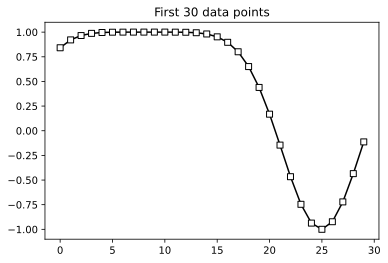

In [72]:
plt.plot(data[:seq_length],'ks-',markerfacecolor='w')
plt.title(f'First {seq_length} data points')
plt.show()

In [74]:
net = RNNNet(ip_size, nHidden, nLayers)

X = torch.rand(seq_length,batchsize,ip_size)

y, h = net(X, None)
print(X.shape)
print(y.shape) # we need only one output per sequence, so we extract the final element of op sequence
print(h.shape)

torch.Size([30, 1, 1])
torch.Size([30, 1, 1])
torch.Size([1, 1, 9])


In [76]:
# testing the model with some data
some_data = data[:seq_length].view(seq_length,1,1)
y = net(some_data, None)

# extracting final value from predicted sequence (first element of tuple op from net)
final_val = y[0][-1]

lossfn = nn.MSELoss()
lossfn(final_val, data[seq_length].view(1,1))

tensor(0.1439, grad_fn=<MseLossBackward0>)

In [77]:
print(y[0][-1])

tensor([[-0.1821]], grad_fn=<SelectBackward0>)


### training model

In [78]:
nEp = 30

# new instance of model and optimizer
net = RNNNet(ip_size, nHidden, nLayers)
optim = torch.optim.SGD(net.parameters(),lr=.001)

# initializing losses
losses = np.zeros(nEp)

# loop over epochs
for i in range(nEp):
    seglosses = []
    segacc = []
    hidden_state = None # reset hidden state every epoch
    
    for timei in range(N-seq_length):
        
        # snippet of data
        X = data[timei:timei+seq_length].view(seq_length,1,1) # say elements of indices t to t+9-1
        y = data[timei+seq_length].view(1,1) # (9-1)th ele is the label
        
        # forward pass
        yH, hidden_state = net(X, hidden_state)
        final_val = yH[-1]
        loss = lossfn(final_val, y)
        
        # backprop
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        # losses from this segment
        seglosses.append(loss.item())
    
    # avg epoch losses
    losses[i] = np.mean(seglosses)
    
    sys.stdout.write('\r' + f'Finished epoch : {i+1}/{nEp}')

Finished epoch : 30/30

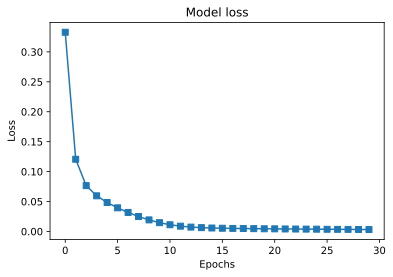

In [80]:
## let's see how the model did!

plt.plot(losses,'s-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss')

plt.show()

### Testing the network on same data

In [82]:
# initialize hidden state

h = np.zeros((N,nHidden))

# initialize predicted val
yH = np.zeros(N)
hh = None
# looping over time segments
for timei in range(N-seq_length):
    X = data[timei:timei+seq_length].view(seq_length,1,1)
    
    yy, hh = net(X, hh)
    yH[timei+seq_length] = yy[-1]
    h[timei+seq_length] = hh.detach()

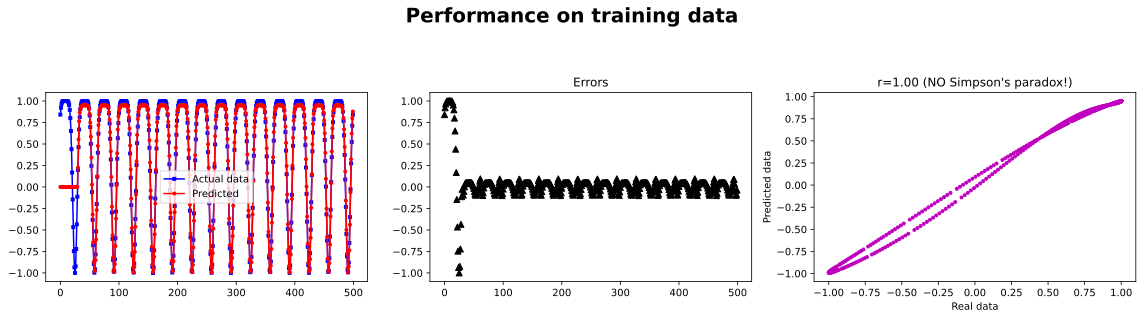

In [88]:
## plot!
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs-',label='Actual data',markersize=3)
ax[0].plot(yH,'ro-',label='Predicted',markersize=3)
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(data-yH,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Errors')

ax[2].plot(data[seq_length:],yH[seq_length:],'mo',markersize=3)
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seq_length:],yH[seq_length:])
ax[2].set_title(f"r={r[0,1]:.2f} (NO Simpson's paradox!)")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

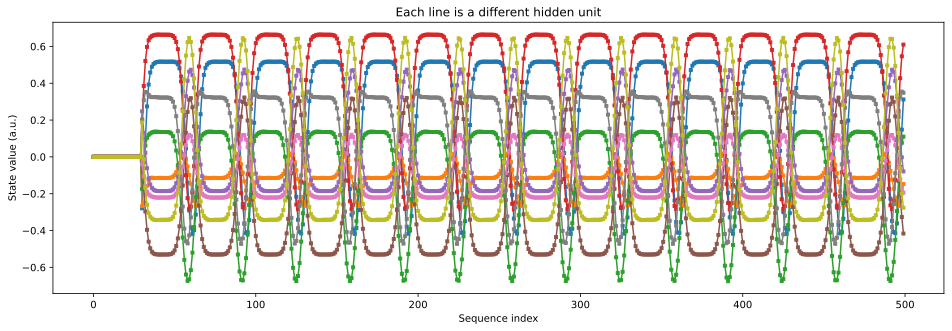

In [89]:
# show the hidden "states" (units activations)
plt.figure(figsize=(16,5))

plt.plot(h,'s-',markersize=3)
plt.xlabel('Sequence index')
plt.ylabel('State value (a.u.)')
plt.title('Each line is a different hidden unit')
plt.show()

### Testing model with new data

In [97]:
# ## Create new data (orange case: different frequency)
# time = torch.linspace(0,10*np.pi,N)
# newData = torch.sin(time+torch.cos(time))

# # Create new data (red case: different function)
time = torch.linspace(0,30*np.pi,N)
newdata = torch.sin(time+torch.sin(time))

In [98]:
# initialize hidden state

h = np.zeros((N,nHidden))

# initialize predicted val
yH = np.zeros(N)
hh = None
# looping over time segments
for timei in range(N-seq_length):
    X = newData[timei:timei+seq_length].view(seq_length,1,1)
    
    yy, hh = net(X, None)
    yH[timei+seq_length] = yy[-1]
    h[timei+seq_length] = hh.detach()
    
truesign = np.sign(newData.numpy())
predsign = np.sign(yH)
signacc = 100*np.mean(truesign[seq_length:]==predsign[seq_length:])

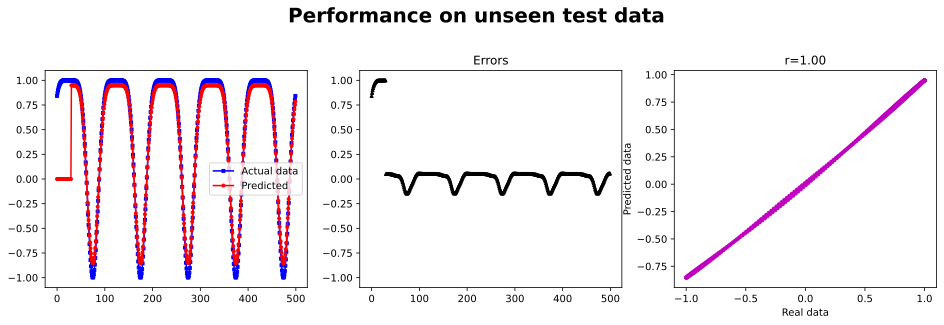

In [99]:
# plotting
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(newData,'bs-',label='Actual data',markersize=3)
ax[0].plot(yH,'ro-',label='Predicted',markersize=3)
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(newData-yH,'k^',markersize=3)
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Errors')

ax[2].plot(newData[seq_length:],yH[seq_length:],'mo',markersize=3)
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(newData[seq_length:],yH[seq_length:])
ax[2].set_title(f"r={r[0,1]:.2f}")

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20,y=1.1)
plt.show()

## Longer term extrapolation

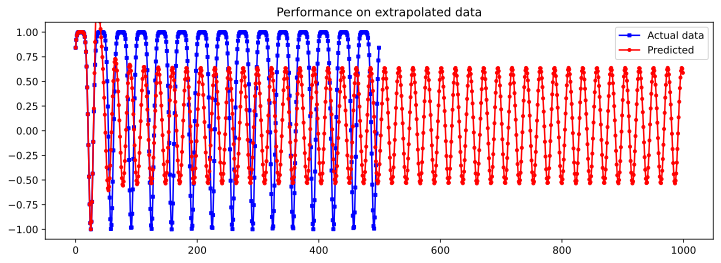

In [100]:
# using original data and creating signals 2X long 

yH = torch.zeros(2*N)
yH[:N] = data
h = None

for timei in range(2*N - seq_length):
    
    X = yH[timei:timei+seq_length].view(seq_length,1,1)
    
    yy, h = net(X, h)
    yH[timei+seq_length] = yy[-1]
    
yH = yH.detach()

# plotting
fig = plt.figure(figsize=(12,4))
plt.plot(data,'bs-',label='Actual data',markersize=3)
plt.plot(yH,'ro-',label='Predicted',markersize=3)
plt.ylim([-1.1,1.1])
plt.legend()
plt.title('Performance on extrapolated data')
plt.show()